In [1]:
import xarray as xr
import pyvista as pv
import numpy as np
pv.set_jupyter_backend('trame')

In [2]:
ds_output = xr.open_dataset(r"C:\Users\leroquan\Documents\00-Work_space\16-Eddy detection\03_swirl\200m_params03\depth_evolution\swirl_03_t0.nc")

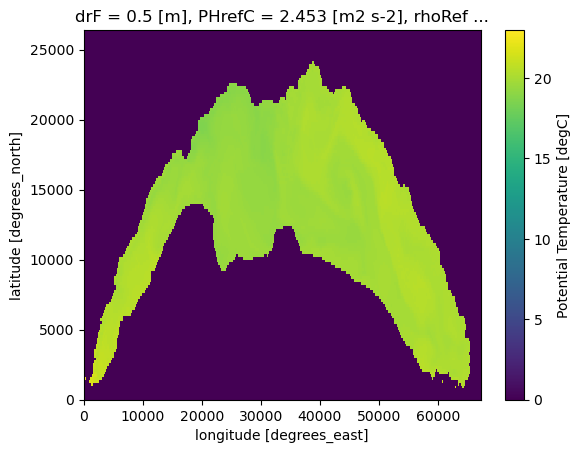

In [3]:
ds_output['THETA'].isel(Z=0).plot()

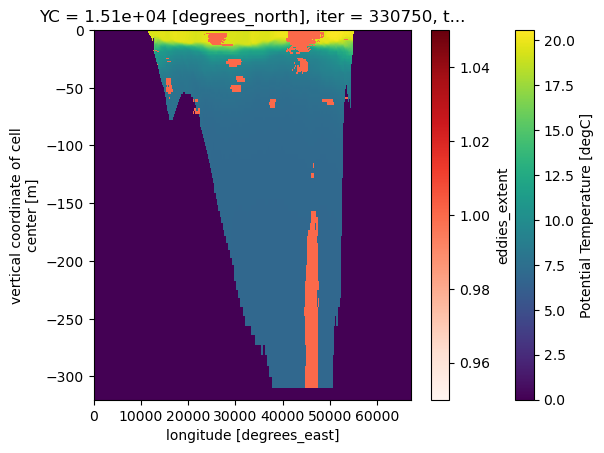

In [4]:
ds_output['THETA'].sel(YC=15100).plot()
ds_output['eddies_extent'].sel(YC=15100).plot(cmap='Reds')

# Rendering without realistic z

In [12]:
np.tile(ds_output.Z.values, (len(ds_output['XC']),len(ds_output['YC']),1)).T

array([[[-2.50000000e-01, -2.50000000e-01, -2.50000000e-01, ...,
         -2.50000000e-01, -2.50000000e-01, -2.50000000e-01],
        [-2.50000000e-01, -2.50000000e-01, -2.50000000e-01, ...,
         -2.50000000e-01, -2.50000000e-01, -2.50000000e-01],
        [-2.50000000e-01, -2.50000000e-01, -2.50000000e-01, ...,
         -2.50000000e-01, -2.50000000e-01, -2.50000000e-01],
        ...,
        [-2.50000000e-01, -2.50000000e-01, -2.50000000e-01, ...,
         -2.50000000e-01, -2.50000000e-01, -2.50000000e-01],
        [-2.50000000e-01, -2.50000000e-01, -2.50000000e-01, ...,
         -2.50000000e-01, -2.50000000e-01, -2.50000000e-01],
        [-2.50000000e-01, -2.50000000e-01, -2.50000000e-01, ...,
         -2.50000000e-01, -2.50000000e-01, -2.50000000e-01]],

       [[-7.57499993e-01, -7.57499993e-01, -7.57499993e-01, ...,
         -7.57499993e-01, -7.57499993e-01, -7.57499993e-01],
        [-7.57499993e-01, -7.57499993e-01, -7.57499993e-01, ...,
         -7.57499993e-01, -7.57499993e

In [9]:
ds_output['eddies_extent'].values.shape

(100, 132, 336)

In [67]:
# Replace NaNs with zero
data = ds_output['eddies_extent'].values
data_no_nan = np.nan_to_num(data, nan=0)

lake = np.tile(ds_output.Z.values, (len(ds_output['XC']),len(ds_output['YC']),1)).T
lake[ds_output['THETA'].values == 0] = lake.min()

# Flip arrays upside down 
data = np.flip(data.T, axis=(0, 1, 2))
data_no_nan = np.flip(data_no_nan.T, axis=(0, 1, 2))
lake = np.flip(lake.T, axis=(0, 1, 2))

# Initialize grid
dims = np.array(data.shape)
grid = pv.ImageData(dimensions=dims, spacing=(1, 1, 1), origin=(0, 0, 0))

# Flatten (Fortran ordering!)
grid.point_data['eddies'] = data_no_nan.flatten(order="F")
grid.point_data['lake'] = lake.flatten(order="F")

# Plot
p = pv.Plotter()
p.add_volume(grid, scalars='eddies', opacity='linear', cmap='viridis')
p.add_volume(grid, scalars='lake', opacity=[0,0.03], cmap='Blues')
p.show()

#p.export_html(r"C:\Users\leroquan\Documents\00-Work_space\16-Eddy detection\03_swirl\200m_params03\depth_evolution\swirl_03_t0_z0_lake_visualization.html")

Widget(value='<iframe src="http://localhost:52077/index.html?ui=P_0x161443a1de0_43&reconnect=auto" class="pyvi…

# Rendering with more realistic z (WIP, doesn't work yet...)

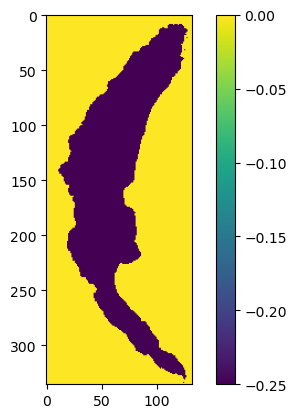

In [91]:
import matplotlib.pyplot as plt
plt.imshow(lake[:,:,-1])
plt.colorbar()

In [96]:
points

array([[ 1.00000000e+02,  1.00000000e+02, -2.50000000e+01],
       [ 3.00000000e+02,  1.00000000e+02, -2.50000000e+01],
       [ 5.00000000e+02,  1.00000000e+02, -2.50000000e+01],
       ...,
       [ 6.67000000e+04,  2.63000000e+04, -3.15119995e+04],
       [ 6.69000000e+04,  2.63000000e+04, -3.15119995e+04],
       [ 6.71000000e+04,  2.63000000e+04, -3.15119995e+04]],
      shape=(4435200, 3))

In [101]:
import numpy as np
import pyvista as pv

# Replace NaNs
data = ds_output['eddies_extent'].values
data_no_nan = np.nan_to_num(data, nan=0)

lake = np.tile(-1*ds_output.Z.values, (len(ds_output['XC']),len(ds_output['YC']),1)).T
lake[ds_output['THETA'].values == 0] = 0

data = np.flip(data.T, axis=(0, 1, 2))
data_no_nan = np.flip(data_no_nan.T, axis=(0, 1, 2))
lake = np.flip(lake.T, axis=(0, 1, 2))

# Coordinate arrays
x = ds_output['XC'].values  # (nx,)
y = ds_output['YC'].values  # (ny,)
z = np.flip(ds_output['Z'].values*100)   # (nz,) — non-uniform

# Create full meshgrid (note order: Z, Y, X)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')  # All shape: (nx, ny, nz)

# Reshape to (N, 3) for StructuredGrid
points = np.c_[X.ravel(order='F'), Y.ravel(order='F'), Z.ravel(order='F')]

# Create the structured grid
nx, ny, nz = data.shape
grid = pv.StructuredGrid()
grid.points = points
grid.dimensions = (nx, ny, nz)  # Important: dimensions, not shape!

# Add data
grid.point_data['eddies'] = data_no_nan.ravel(order='F')
grid.point_data['lake'] = lake.ravel(order='F')

# Show contours for 'eddies'
#contours = grid.contour(isosurfaces=[0.1], scalars='eddies')
p = pv.Plotter()
p.add_mesh(grid.threshold(value=0.1, scalars='eddies'), cmap='Blues', opacity=1)
#p.add_mesh(contours, cmap='viridis')

# Optional lake transparency
p.add_mesh(grid.threshold(value=0.1, scalars='lake'), cmap='Blues', opacity=0.1)
p.show()

#p.export_html(r"C:\Users\leroquan\Documents\00-Work_space\16-Eddy detection\03_swirl\200m_params03\depth_evolution\swirl_03_t0_z0_realistic_z.html")

Widget(value='<iframe src="http://localhost:52077/index.html?ui=P_0x16162cc98a0_55&reconnect=auto" class="pyvi…

In [4]:
x = ds_output['XC'].values  # x-coordinates (1D array)
y = ds_output['YC'].values  # y-coordinates (1D array)
z = ds_output['Z'].values   # z-coordinates (1D array)

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Flatten the coordinate arrays
points = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))

In [5]:
# Create StructuredGrid
grid = pv.StructuredGrid()
grid.points = points

In [6]:
# Set the dimensions (nx, ny, nz) - match your coordinate arrays length
grid.dimensions = (len(x), len(y), len(z))

# Add your scalar data (flattened)
grid['data'] = data_no_nan.ravel(order='F')  # Fortran order might be needed

In [7]:
opacity = [0, 1]
grid.plot(volume=True, opacity=opacity)

Widget(value='<iframe src="http://localhost:58627/index.html?ui=P_0x1ac27e21ba0_1&reconnect=auto" class="pyvis…